In [1]:
## Cell 1: Imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os


In [ ]:
## Cell 2: Setup and Data Generators
# Base directory
base_dir = os.path.join("data", "EuroSAT_RGB")

# Image dimensions
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # IMPORTANT: Do not shuffle in validation
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [3]:
## Cell 3: Model Architecture and Compilation
# Load base model
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# Fine-tuning: freeze early layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
## Cell 4: Training the Model
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop]
)


In [ ]:
## Cell 5: Save the Model
# Save trained model
model.save("eurosat_mobilenetv2.h5")


In [6]:
## Cell 6: Evaluation Metrics
# Predictions
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=4
)
print("Classification Report:\n")
print(report)

# Final validation accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")


169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step
Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop     0.9396    0.9333    0.9365       600
              Forest     0.9269    0.9717    0.9487       600
HerbaceousVegetation     0.9287    0.8683    0.8975       600
             Highway     0.8864    0.9360    0.9105       500
          Industrial     0.9547    0.9700    0.9623       500
             Pasture     0.9595    0.7700    0.8544       400
       PermanentCrop     0.8976    0.9120    0.9048       500
         Residential     0.9881    0.9683    0.9781       600
               River     0.8446    0.9460    0.8925       500
             SeaLake     0.9834    0.9850    0.9842       600

            accuracy                         0.9307      5400
           macro avg     0.9309    0.9261    0.9269      5400
        weighted avg     0.9325    0.9307    0.9303      5400

Final Validation Accuracy: 93.07%


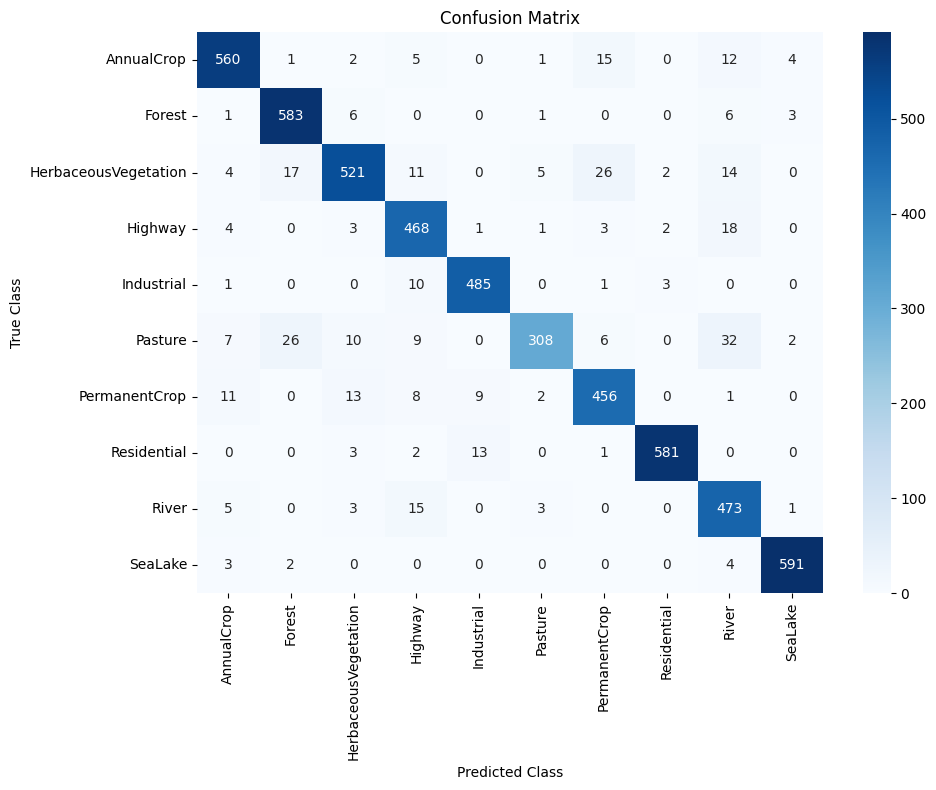

In [7]:
## Cell 7: Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()
